# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

Выполнили Денисова Екатерина и Заиц Георгий 411
## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import ArrayLike

In [4]:
# загрузка и подготовка данных

tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']
start_date = '2020-04-01'
end_date = '2022-04-22'

stock_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    stock_data[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

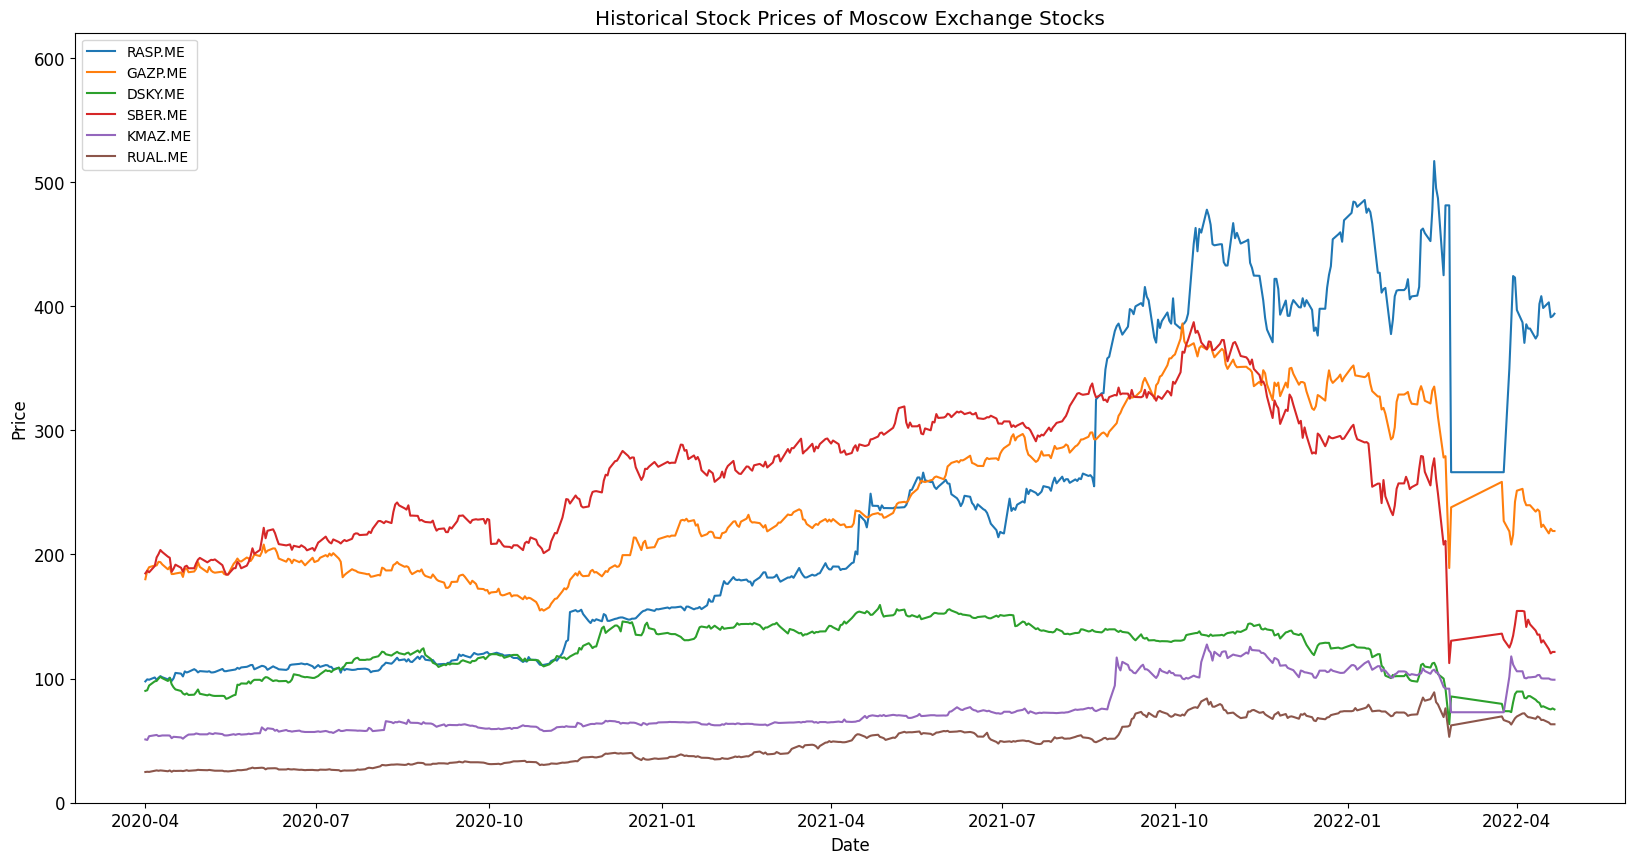

In [5]:
# красивая визуализация на графике с подписями и адекватным масштабом

plt.figure(figsize=(20,10))
for ticker in tickers:
    plt.plot(stock_data.index, stock_data[ticker], label=ticker)

plt.legend(loc='upper left', fontsize='medium')
plt.title('Historical Stock Prices of Moscow Exchange Stocks', fontsize='x-large')
plt.xlabel('Date', fontsize='large')
plt.ylabel('Price', fontsize='large')
plt.tick_params(axis='both', which='major', labelsize='large')
plt.ylim([0, max(stock_data.max())*1.2])

plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


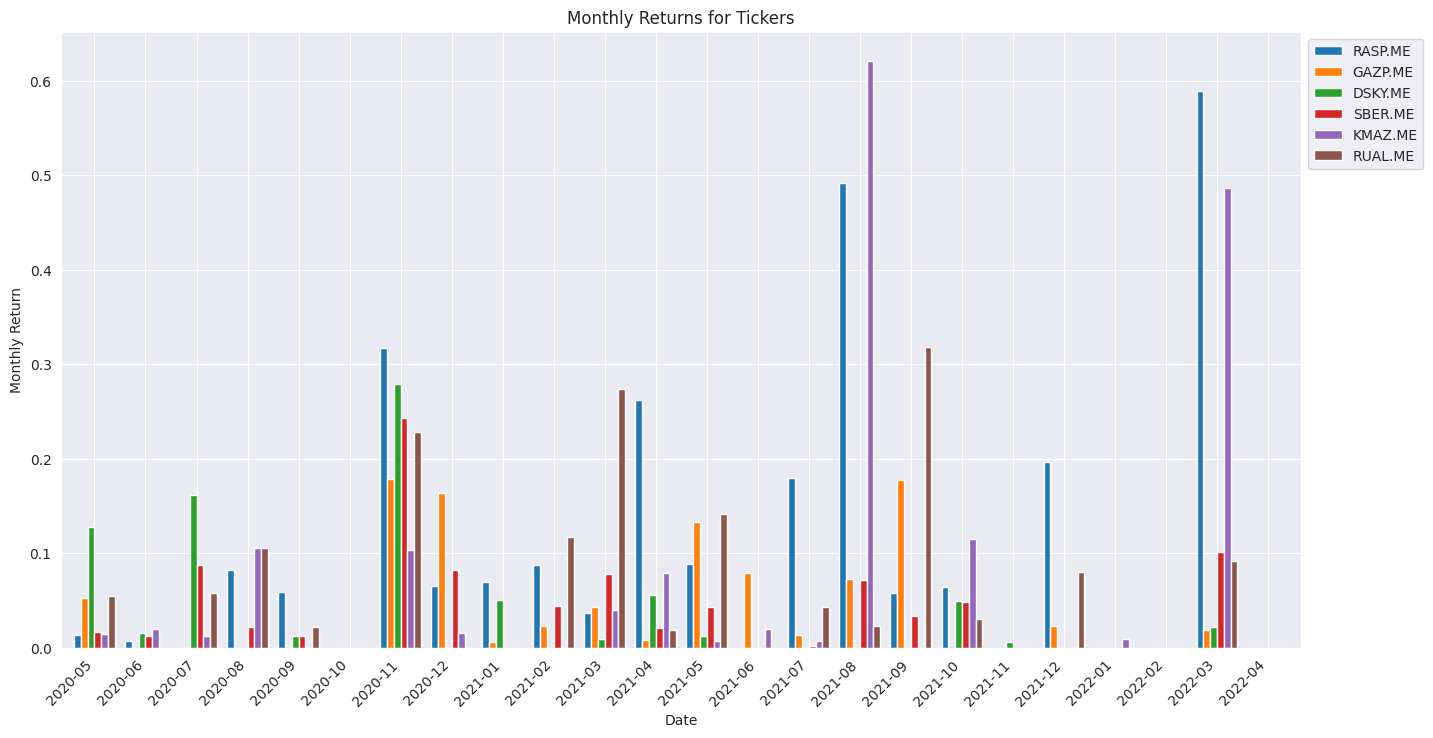

In [6]:
# место для кода
# Calculate the monthly returns for each ticker
monthly_returns = stock_data.resample('M').last().pct_change().clip(lower=0).dropna()

# Convert the index to datetime
monthly_returns.index = pd.to_datetime(monthly_returns.index).strftime('%Y-%m')

# Plot the monthly returns as a bar chart
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(16, 8))
monthly_returns.plot(kind='bar', width=0.8, ax=ax)
plt.title('Monthly Returns for Tickers')
plt.xlabel('Date')
plt.ylabel('Monthly Return')

# Format the x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
# Загрузка данных для тикеров за указанный период времени
dfs = []
for ticker in tickers:
    df = yf.download(ticker, start='2020-04-01', end='2022-04-22')
    df['pct_change'] = df['Close'].pct_change().clip(lower=0)
    dfs.append(df[['pct_change']])

# Объединение данных в одну таблицу
df = pd.concat(dfs, axis=1)
df.columns = tickers

# Удаление строк с пропущенными значениями
df = df.dropna()

# Преобразование индекса в нужный формат
df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')

# Добавление заголовка к таблице
df = pd.DataFrame(df.values, columns=[f"{ticker}" for ticker in tickers], index=df.index).rename_axis("Date")
df.index.name = "Date"
df.columns.name = "Tikers"

# Форматирование таблицы с помощью функции Styler
styled_table = (
    df.style.format("{:.2%}")
    .background_gradient(cmap='YlGn', axis=None)
    .set_properties(**{'font-size': '12pt', 'text-align': 'center'})
    .set_table_attributes('border="1" class="dataframe table table-striped table-hover table-bordered"')
    .set_caption('<h2>Market Returns</h2><p style="text-align:center;">')
)

# Вывод таблицы
display(styled_table)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Tikers,RASP.ME,GAZP.ME,DSKY.ME,SBER.ME,KMAZ.ME,RUAL.ME
Date,,,,,,
2020-04-02,1.68%,3.88%,0.55%,1.17%,0.00%,0.81%
2020-04-03,0.00%,1.46%,4.19%,0.00%,5.93%,0.00%
2020-04-06,1.84%,0.70%,3.58%,2.73%,1.49%,3.73%
2020-04-07,0.00%,0.06%,0.33%,3.63%,0.37%,1.15%
2020-04-08,1.72%,1.51%,1.92%,1.35%,0.00%,0.00%
2020-04-09,1.29%,0.00%,1.46%,1.66%,0.37%,1.07%
2020-04-10,0.00%,0.00%,0.00%,0.00%,0.56%,0.00%
2020-04-13,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2020-04-14,1.39%,1.08%,2.45%,0.00%,0.00%,2.58%


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

*Место для выкладок.*

Градиент функции $f_t(x)$ обозначается через $\nabla f_t(x)$. Если $f_t(x)$ является дифференцируемой функцией, то $\nabla f_t(x)$ задается градиентом $f_t(x)$ относительно $x$. Другими словами, это вектор, компоненты которого являются частными производными от $f_t(x)$ по каждой переменной $x_i$.

Что касается явной формулы для итерации OGD, то она выглядит следующим образом:
$$
x_{t+1}=\operatorname{П}_D\left(x_t-a_t \nabla f_t\left(x_t\right)\right)
$$

где $\text{П}_D$ - оператор проекции на выпуклое множество $D$, а $a_t$ - размер шага на итерации $t$. Эта формула представляет правило обновления для алгоритма OGD на каждой итерации, где мы перемещаем текущую итерацию $x_t$ в направлении, противоположном градиенту функции $f_t(x)$, масштабируемую на размер шага $\eta_t$, а затем проецируем результирующую точку на множество $K$, чтобы гарантировать, что это остается осуществимым.

Чтобы вычислить градиент $-\log r_t^{\top} x$, мы используем цепное правило следующим образом:

$$
\begin{aligned}
\nabla_x\left(-\log r_t^{\top} x\right) &= -\frac{1}{r_t^{\top} x}\nabla_x(r_t^{\top}x) = -\frac{r_t}{r_t^{\top}x}
\end{aligned}
$$

где $r_t$ - фиксированный $d$-мерный вектор.

Теперь, используя приведенное выше выражение для градиента, уравнение обновления для онлайн-градиентного спуска (OGD) можно записать в виде:

$$
x_{t+1} = \Pi(x_t - \eta_t\nabla_x(-\log r_t^{\top}x))
$$

где $\Pi(\cdot)$ - оператор проекции на допустимое множество, а $\eta_t$ - размер шага в момент времени $t$. Явная формула для итераций OGD может быть записана в виде:

$$
x_{t+1} = \Pi\left(x_t + \frac{\eta_t r_t}{r_t^\top x_t}\right)
$$

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [ ]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [ ]:
# реализация онлайн градиентного спуска
def online_gradient_descent(investment_returns, num_iterations, step_size):
    """Возвращает долю инвестиций после запуска онлайн-градиентного спуска."""
    num_investments = len(investment_returns)
    investment_proportions = np.zeros(num_investments)
    investment_proportions[0] = 1.0 / num_investments

    for i in range(num_iterations):
        gradient = np.zeros(num_investments)
        for j in range(num_investments):
            gradient[j] = investment_returns[j] / np.dot(investment_proportions, investment_returns)
        investment_proportions -= step_size * gradient
        investment_proportions = simplex_projection(investment_proportions)

    return investment_proportions

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

*Место для выкладок.*

Существуют различные способы выбора величины $\alpha_k$ в методе

$$
x_{k+1}=x_k-\alpha_k f^{\prime}\left(x_k\right), \quad \alpha_k>0, \quad k=0,1, \ldots
$$
В зависимости от способа выбора $\alpha_k$ можно получить различные варианты градиентного метода. Укажем несколько наиболее употребительных на практике способов выбора $\alpha_k$.

Возможен выбор $\alpha_k$:
$$
f\left(x_k\right)-f\left(x_k-\alpha_k f^{\prime}\left(x_k\right)\right) \geqslant \varepsilon \alpha_k\left|f^{\prime}\left(x_k\right)\right|^2, \quad \varepsilon>0 .
$$
Для удовлетворения условия выше сначала обычно берут некоторое число $\alpha_k=\alpha>0$ (одно и то же на всех итерациях; например, $\alpha_k=1$ ), а затем при необходимости дробят его, т. е. изменяют по закону $\alpha_k=\lambda^i \alpha, i=0,1 \ldots$ $0<\lambda<1$, до тех пор, пока впервые не выполнится условие выше. Такой способ определения $\alpha_k$ в литературе часто называют выбором шага по Армихо.

Возможно априорное задание величин $\alpha_k$ из условий
$$
\alpha_k>0, \quad k=0,1, \ldots ; \quad \sum_{k=0}^{\infty} \alpha_k=\infty, \quad \sum_{k=0}^{\infty} \alpha_k^2<\infty .
$$
Например, в качестве $\alpha_k$ можно взять $\alpha_k=c(k+1)^{-\alpha}$, где $c=$ const $>0$, а число $\alpha$ таково, что $1 / 2<\alpha \leqslant 1$. В частности, если $\alpha=1, c=1$, то получим $\alpha_k=(k+1)^{-1}, k=0,1, \ldots$ Такой выбор $\left\{\alpha_k\right\}$ очень прост для реализации, но не гарантирует выполнения условия монотонности $f\left(x_{k+1}\right)<f\left(x_k\right)$ и, вообще говоря, сходится медленно.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [ ]:
# красивая визуализация на графике с подписями и адекватным масштабом

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [ ]:
# место для кода
from scipy.optimize import minimize

def online_newton_method(f, grad, x0, D, gamma=1.0, epsilon=1e-4, max_iter=100, tol=1e-6):
    """
    Реализация онлайн метода Ньютона для оптимизации функции f на множестве D
    :param f: функция потерь
    :param grad: градиент функции потерь
    :param x0: начальная точка
    :param D: множество, на котором ищем минимум
    :param gamma: шаг метода
    :param epsilon: начальное значение матрицы A
    :param max_iter: максимальное число итераций
    :param tol: требуемая точность
    :return: найденная точка минимума
    """
    x = x0.copy()
    A = epsilon * np.eye(len(x))
    for i in range(max_iter):
        ft = f(x)
        gradt = grad(x)
        At = A + np.outer(gradt, gradt)
        y = x - (1 / gamma) * np.linalg.inv(At) @ gradt
        x = projection(y, D, At)
        A = At
        if np.linalg.norm(x - y) < tol:
            break
    return x

def projection(y, D, A=None):
    """
    Оператор проектирования на множество D
    :param y: точка, которую нужно спроецировать
    :param D: множество, на которое нужно спроецировать
    :param A: матрица A для оператора проектирования на множество D
    :return: спроецированная точка
    """
    if A is None:
        A = np.eye(len(y))
    dist = lambda x: np.sqrt((x - y) @ A @ (x - y))
    x_opt = minimize(lambda x: dist(x), x0=np.zeros_like(y), bounds=D, method='L-BFGS-B').x
    return x_opt